In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import getcwd, listdir, path
import sys

In [3]:
python_modules_path = path.join(
    getcwd(), 
    "drive/MyDrive/python_modules/pytorch_unet")
python_modules_path

'/content/drive/MyDrive/python_modules/pytorch_unet'

In [4]:
listdir(python_modules_path)

['plot_utils.py',
 'data_generator.py',
 'losses.py',
 'unet.py',
 'dataset_generator.py',
 '__pycache__',
 'utils.py']

In [5]:
sys.path.append(python_modules_path)

In [19]:
import dataset_generator, data_generator, unet, losses, utils, plot_utils

In [7]:
# plot_utils.plot_losses(dict(train=dict(bce=[0.1, .02]), valid=dict(bce=[0.1, .02])))

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
from time import time

In [9]:
(BATCH_SIZE,
 TARGET_CHANNELS,
 HEIGHT, 
 WIDTH, 
 N_SAMPLES_TRAIN,
 N_SAMPLES_VALID,
 N_SAMPLES_TEST)   = 32, 6, 128, 128, 2000, 400, 200

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
trfms = transforms.Compose([transforms.ToTensor()])

train_dataset = dataset_generator.CustomDataset(
    height=HEIGHT, 
    width=WIDTH, 
    n_samples=N_SAMPLES_TRAIN,
    transform=trfms)

valid_dataset = dataset_generator.CustomDataset(
    height=HEIGHT, 
    width=WIDTH, 
    n_samples=N_SAMPLES_VALID,
    transform=trfms)

test_dataset = dataset_generator.CustomDataset(
    height=HEIGHT, 
    width=WIDTH, 
    n_samples=N_SAMPLES_TRAIN,
    transform=trfms)

Image shape: (128, 128, 3)


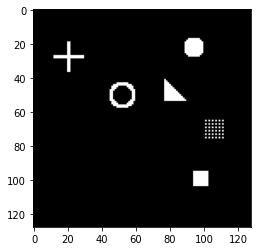

In [12]:
i = np.random.choice(N_SAMPLES_TRAIN)
img = utils.inverse_transform(train_dataset.__getitem__(i)[0])
print(f"Image shape: {img.shape}")
plt.imshow(img)
plt.show()

In [13]:
data_loaders = {
    "train": DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=True),
    "valid": DataLoader(
      dataset=valid_dataset,
      batch_size=BATCH_SIZE, 
      shuffle=True),
    "test": DataLoader(
        dataset=test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False)}

In [14]:
model = unet.UNet(n_class=TARGET_CHANNELS)
model.to(device)
summary(model, input_size= next(iter(data_loaders["train"]))[0][0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [15]:
def fit(data_loaders, model, optimizer, num_epochs):

  track_epoch_loss_metrics = dict(train=dict(bce=[], dice=[], total=[]),
                                  valid=dict(bce=[], dice=[], total=[]))
  min_valid_loss = 1e10
  for epoch in range(num_epochs):
    start_time = time()
    print(f"{'-'*5} Epoch: {epoch} {'-'*5}")
    for mode in ["train", "valid"]:
      
      if mode == "train":
        model.train() # read the documentation
      else:
        model.eval() # read the documentation
      
      total_batch_loss_metrics = dict(bce=0.0, dice=0.0, total=0.0)
      for input_images, target_masks_true in data_loaders[mode]:
        input_images = input_images.to(device)
        target_masks_true = target_masks_true.to(device)

        # setting inital parameter gradients to zero before backprop
        optimizer.zero_grad()
  
        # enabling gradient only at time of training 
        with torch.set_grad_enabled(mode == "train"):
          target_masks_pred = model.forward(input_images)
          loss = losses.total_loss(target_masks_pred=target_masks_pred, 
                                   target_masks_true=target_masks_true, 
                                   loss_metrics=total_batch_loss_metrics)
          if mode == "train":
            loss.backward() # backprop to calculate gradients
            optimizer.step() # optimizer to update model params

      # Saving loss history throughout all epochs
      for k in total_batch_loss_metrics.keys():
        track_epoch_loss_metrics[mode][k].append(total_batch_loss_metrics[k])

      # saving best model based on least validation loss
      if mode == "valid" and total_batch_loss_metrics["total"] < min_valid_loss:
        print("Saving best model")
        min_valid_loss = total_batch_loss_metrics["total"]
        best_model_weights = deepcopy(model.state_dict())

    plot_utils.plot_losses(track_epoch_loss_metrics)
    
    epoch_time = time() - start_time
    print(f"{epoch_time // 60: .0f}m {epoch_time % 60: .0f}s")
  
  # loading best model weights
  model.load_state_dict(best_model_weights)
  return model

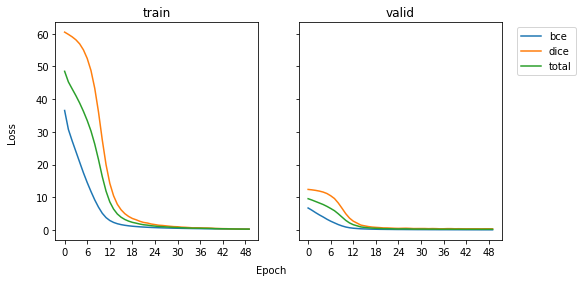

 0m  29s


In [16]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LEARNING_RATE)
model = fit(data_loaders=data_loaders,
            model=model, 
            optimizer=optimizer,
            num_epochs=NUM_EPOCHS)

In [17]:
# setting model to evaludate mode
model.eval()
test_input_images, test_target_masks_true = next(iter(data_loaders["test"]))
test_input_images = test_input_images.to(device)
test_target_masks_true = test_target_masks_true.to(device)

test_target_masks_pred = torch.sigmoid(
    model.forward(test_input_images))

In [20]:
test_input_images_color_mapped_true = [data_generator.masks_to_colorimg(x) for x in test_target_masks_true.data.cpu().numpy()]

test_input_images_color_mapped_pred = [data_generator.masks_to_colorimg(x) for x in test_target_masks_pred.data.cpu().numpy()]

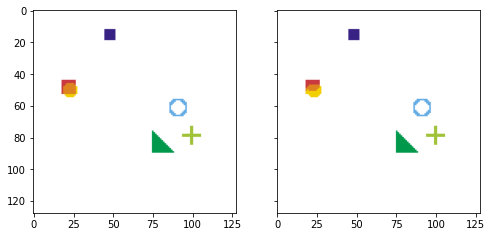

In [25]:
plot_utils.plot_side_by_side(test_input_images_color_mapped_true[4], 
                             test_input_images_color_mapped_pred[4])